#### Trial identification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import math
import matplotlib.patches as patches
from arena import *
import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from sklearn.feature_selection import mutual_info_regression as mi_skl
import seaborn as sns
from scipy import stats
import time
from matplotlib import gridspec
from math import pi
from collections import Counter
from scipy.spatial import distance
from tqdm import tqdm, trange

def standardize_coordinates(META, sw_x, sw_y, bl_x, bl_y, w_x, w_y, cxn_x, cxn_y):
    """Standardize all arena coordinates so that the bottom left of the arena is 0,0.
    In instances of strange startbox activity, a prompt is sent out to the user to check"""
    fig, ax = plt.subplots(figsize=(2,2), dpi=100)
    plt.plot(META['cap_x'], META['cap_y'],c='red', linewidth=0.1, zorder=0) # plot dlc        
    plt.scatter(sw_x, sw_y, c='lightblue', s=50, alpha = 0.2, edgecolors='k') #plot sws
    rect = patches.Rectangle((bl_x, bl_y), w_x, w_y, linewidth=0.2, edgecolor='k', facecolor='none')
    ax.add_patch(rect) #plot arena
    ax.invert_yaxis()
    plt.axis('off')
    plt.show()
    correction = input("Should this one be corrected - y/n?")
    if correction == 'y':
        META['cap_x'] -= cxn_x ; META['cap_y'] -= cxn_y
        META['leftear_x'] -= cxn_x; META['leftear_y'] -= cxn_y
        META['rightear_x'] -= cxn_x; META['rightear_y'] -= cxn_y
    return META

def sw_naming(sw_x, sw_y):
    """Names each of the six sandwells based on the SW coordinate input"""
    sw_xord = np.array(sorted(sw_x.copy()))
    sw_yord = np.array(sorted(sw_y.copy()))
    for i in range(6):
        if sw_x[i] in sw_xord[:2] and sw_y[i] in sw_yord[:2]:
            SW1 = [sw_x[i], sw_y[i]]
        elif sw_x[i] in sw_xord[-2:] and sw_y[i] in sw_yord[:2]:
            SW2 = [sw_x[i], sw_y[i]]
        elif sw_x[i] in sw_xord[:2] and sw_y[i] in sw_yord[-2:]:
            SW5 = [sw_x[i], sw_y[i]]
        elif sw_x[i] in sw_xord[-2:] and sw_y[i] in sw_yord[-2:]:
            SW6 = [sw_x[i], sw_y[i]]
        elif sw_x[i] - sw_xord[0] < sw_xord[-1] - sw_x[i]:
            SW3 = [sw_x[i], sw_y[i]]
        else:
            SW4 = [sw_x[i], sw_y[i]]
    return {1:SW1, 2:SW2, 3:SW3, 4:SW4, 5:SW5, 6:SW6}

def startbox_indexs(META, bl_y, tr_x, tr_y, bl_x):
    """Defines the indexes of all startbox activity"""
    #Identify the startbox
    if ego_allo == 'Ego':
        SBS = [META['Combo'].values[0][0]]
    else: #ADAPT FOR ALLO TOO
        SBS = [META['Combo'].values[0][0], META['Combo'].values[0][1]]
    RW = META['Rewarded well'].values[0]

    #Define Starting SB xy coordinates
    SBS_idxs = []
    if 'N' in SBS:
        SB_idxs = list(META[META['cap_y'] < bl_y].index)
        SBS_idxs += SB_idxs
        META.loc[SB_idxs, 'Location'] = 'N'
    if 'E' in SBS:
        SB_idxs = list(META[META['cap_x'] > tr_x].index)
        SBS_idxs += SB_idxs
        META.loc[SB_idxs, 'Location'] = 'E'
    if 'S' in SBS:
        SB_idxs = list(META[META['cap_y'] > tr_y].index)
        SBS_idxs += SB_idxs
        META.loc[SB_idxs, 'Location'] = 'S'
    if 'W' in SBS:
        SB_idxs = list(META[META['cap_x'] < bl_x].index)
        SBS_idxs += SB_idxs
        META.loc[SB_idxs, 'Location'] = 'W'
    MetaSB = META.loc[SBS_idxs].sort_index()
    return MetaSB, SBS, RW

def Trial_indexes(MetaSB, SB_thresh, ego_allo):
    """Indexes for each SAM/CHO trial"""
    SB1 = META['Combo'].values[0][0]
    if ego_allo == 'Ego':
        MetaSB = MetaSB[MetaSB['Location'] == SB1]
        SB2 = META['Combo'].values[0][0]
    else:
        SB2 = META['Combo'].values[0][1]
        MetaSB = MetaSB[MetaSB['Location'].isin([SB1, SB2])]

    #first Trial
    TR_idxs = []; start = MetaSB.index[0]
    for i, idx in enumerate(MetaSB.index):
        if i > 0:
            if idx - MetaSB.index[i-1] > SB_thresh*20: #Jump in index (Possible trial end)
                if ego_allo == 'Allo' and len(TR_idxs) == 0 and MetaSB.loc[idx]['Location'] == SB2:
                    if MetaSB.index[i+(SB_thresh*20)] - idx <= SB_thresh*20:
                        TR_idxs.append(np.arange(start,idx-1,1))
                        start = idx
                        MetaSB = MetaSB[MetaSB['Location'] == SB2]
                        break
                elif ego_allo == 'Ego':
                    if idx - MetaSB.index[i-1] > SB_thresh*20:
                        TR_idxs.append(np.arange(start,idx-1,1))
                        start = idx
    #Second Trial     
    for i, idx in enumerate(MetaSB.index):
        if idx > start:
            if idx - MetaSB.index[i-1] > SB_thresh*20: #Jump in index (Possible trial end)
                if ego_allo == 'Allo' and len(TR_idxs) > 0:  
                    if MetaSB.index[i+(SB_thresh*20)] - idx <= SB_thresh*20:
                        TR_idxs.append(np.arange(start,idx-1,1))
                        
    
    return TR_idxs

def Trial_indexes_outbound(TR_idxs, META, SWS, pix_cm = 5.2):
    """Isolates the outbound trial indexes"""
    TR_OB_idxs = []; T_status = []
    for trial, idxs in enumerate(TR_idxs):
        MetaTR = META.loc[idxs]
        T_RW = MetaTR['Rewarded well'].values[0]
        RW_xy = SWS[int(T_RW)]
        T_xy = MetaTR[['cap_x', 'cap_y']].values
        RW_idx = idxs[[i for i, xy in enumerate(T_xy) if distance.euclidean(RW_xy, xy) < 5 * pix_cm]]

        if len(RW_idx) > 0: #Label correct vs incorrect trials
            OB = MetaTR.loc[:RW_idx[0]]
            OB_xy = OB[['cap_x', 'cap_y']].values
            OB_idx = OB.index
            TR_OB_idxs.append(OB_idx)
            SWSxy = [SWS[sw] for sw in SWS if sw != T_RW]
            iSW_idx = []
            for sw in SWSxy:
                iSW_idx.append(idxs[[i for i, xy in enumerate(OB_xy) if distance.euclidean(sw, xy) < 5 * pix_cm]])
                iSW_idx = [i for i in iSW_idx if len(i) > 0]
            if len(iSW_idx) > 1:
                T_status.append(['Incorrect', len(iSW_idx)])
            elif len(iSW_idx) > 0 and len(iSW_idx[0]) > 20:
                T_status.append(['Incorrect', 1])
            else:
                T_status.append(['Correct'])
        else:
            TR_OB_idxs.append([])
            T_status.append(['Incorrect', 0])
    return TR_OB_idxs, T_status

def speed(xy, pix_cm = 65/20, framerate = 20/2):
    """ Calculate the speed in cm/s and label as movin
    INPUT:
    -----
    xy = array of x and y coordinates
    pix_cm = how many pixels there are in a cm (default 65/20)
    framerate = the number of frames in a second (default (20))
    
    OUPUT:
    -----
    v = array with speed for each frame cm/s
    moving = array of movement status for each frame
    (>= 4cm/s is considered moving)"""
    
    #Calculate speed
    c = np.array([]); moving = np.array([])
    window = framerate
    for pos in range(len(xy)):
        if len(xy) - window <= framerate+1:
            speed = 0
            c = np.append(c,speed)
        else:
            speed = distance.euclidean(xy[pos],xy[window])/pix_cm
            c = np.append(c, speed)
        #Add labels
        if speed >= 4: #cms/second
            moving = np.append(moving, 'moving')
        else:
            moving = np.append(moving, 'stationary')
        window += 1
    #smooth speed with std 1
    c = gaussian_filter(c, sigma=1)
    return c, moving

def sb_cells_ordered(SB_activity, SB_cells):
    """Orders the neurons firing in the startbox"""
    cell_ts = pd.DataFrame({'Cell':[], 'Timestamp':[]})
    for cell in SB_activity[SB_cells].columns:
        ts = [i for i, e in enumerate(SB_activity[cell]) if e > 0]
        cell_ts = pd.concat([cell_ts, pd.DataFrame({'Cell':cell, 'Timestamp':ts})], ignore_index=True)
    ts_ord = cell_ts.sort_values('Timestamp', ascending=True)
    return ts_ord

def add_arena_details(sw_x, sw_y, SWS, bl_x, bl_y, w_x, w_y):
    """Plotting feature to add particular arena features"""
    plt.scatter(sw_x, sw_y, c='lightblue', s=50, alpha = 0.2, edgecolors='k') #plot sws
    for i in range(1,7): plt.text(SWS[i][0],SWS[i][1], i, ha="center", va="center", fontsize=4)
    rect = patches.Rectangle((bl_x, bl_y), w_x, w_y, linewidth=0.2, edgecolor='k', facecolor='none')
    ax.add_patch(rect) #plot arena
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(ax.spines.values(), color=None)
    plt.xlim(-300,1000)
    plt.ylim(-300,1000)
    ax.set_ylim(ax.get_ylim()[::-1])
    return

def update_trials(All_META):
    """Update the trial number for all trials"""
    All_META = All_META.reset_index(drop=True)
    Sessions = np.unique(All_META['Session'])
    for session in Sessions:
        for stage in ['SAM', 'CHO']:
            Meta_st = All_META.loc[(All_META['Session'] == session) &(All_META['Stage'].str.contains(stage))]
            t = 1
            for trial_split in sorted(np.unique(Meta_st['TRIALS'])):
                Meta_tsplit = Meta_st[Meta_st['TRIALS'] == trial_split]
                for trial in sorted(np.unique(Meta_tsplit['Trial'])):
                    Meta_TR = Meta_tsplit.loc[(Meta_tsplit['Trial'] == trial)]
                    All_META.loc[list(Meta_TR.index), 'Trial'] = t
                    t+=1
    return All_META

def add_combination(homeDir, All_META, Animal_ID, save=False):
    #Read in all animals df
    COMBO_df = pd.read_csv(os.path.join(homeDir, 'Data/ANIMAL_Trial_Combinations.csv'))

    #identify common combinations (To do - find correlation between outbound)
    Sessions = np.unique(All_META['Session'])
    Sess = []; Stg = []; Tr = []
    SB_st = []; SB_ed = []; RW = []; T_cor = []; Combo = []
    for session in Sessions:
        for stage in ['SAM', 'CHO']:
            Meta_st = All_META.loc[(All_META['Session'] == session) &(All_META['Stage'].str.contains(stage))]
            t = 1
            for trial_split in sorted(np.unique(Meta_st['TRIALS'])):
                Meta_tsplit = Meta_st[Meta_st['TRIALS'] == trial_split]
                for trial in sorted(np.unique(Meta_tsplit['Trial'])):
                    Meta_TR = Meta_tsplit.loc[(Meta_tsplit['Trial'] == trial)]
                    sb_st = Meta_TR[Meta_TR['Trial Startbox'] != 0]['Trial Startbox'].values[0] #trial start startbox  
                    sb_ed = Meta_TR['Combo'].values[0][-1] #trial end startbox  
                    rw = Meta_TR['Rewarded well'].values[0] #trial rewarded well
                    Sess += [session]; Stg += [stage]; Tr += [str(t)] #Meta
                    T_cor += [Meta_TR['Trial Status'].values[0]] #correctness
                    SB_st += [sb_st]
                    SB_ed += [sb_ed]
                    RW += [rw]
                    Combo += [sb_st + str(rw)] #Trial combo
                    t+=1

    #Create df of all SB, SW combinations
    Combo_df = pd.DataFrame({'Animal':Animal_ID, 'SB Start':SB_st, 'SB End':SB_ed, 'RW':RW, 'Combo':Combo,'Correctness':T_cor, 
                             'Session':Sess, 'Stage':Stg, 'Trial':Tr})
    
    #Count the number of correct trial combos
    for combo in np.unique(Combo_df['Combo']):
        T_combo = Combo_df.loc[(Combo_df['Combo']==combo) & (Combo_df['Correctness']=='Correct')]
        Combo_df.loc[(Combo_df['Combo']==combo) & (Combo_df['Correctness']=='Correct'), 'n Correct'] = len(T_combo)
    Combo_df = Combo_df.sort_values('n Correct', ascending=False)
    if save: #Add animal combo info to all animal csv
        COMBO_df = pd.concat([COMBO_df, Combo_df], ignore_index=True)
        COMBO_df.to_csv(os.path.join(homeDir, 'Data/Animal_Trial_Combinations.csv'), index=False)
    return Combo_df

def get_symmetric_combo(combo, Combo_df):
    """Return the symmetrical combination of a trial startbox reward well"""
    if combo in list(Combo_dic['Symmetric'].keys()):
        symmetric_combo = Combo_dic['Symmetric'][combo]
    else:
        symmetric_combo = list(Combo_dic['Symmetric'].keys())[list(Combo_dic['Symmetric'].values()).index(combo)]
    return symmetric_combo

def get_control_combo(combo, Combo_df):
    if combo in list(Combo_dic['Control'].keys()):
        control_combo = Combo_dic['Control'][combo]
        control_combo = [control_combo, get_symmetric_combo(control_combo, Combo_dic)]
    else:
        control_combo = list(Combo_dic['Control'].keys())[list(Combo_dic['Control'].values()).index(combo)]
        control_combo = [control_combo, get_symmetric_combo(control_combo, Combo_dic)]
    return control_combo

def combo_startbox_cells(All_META, combo_t, wdw=10):
    #Trial neural activity
    meta_t = All_META.loc[(All_META['Session']==combo_t['Session']) &
                          (All_META['Stage'].str.contains(combo_t['Stage'])) &
                          (All_META['Trial']==int(combo_t['Trial']))]

    Start_idx = meta_t[meta_t['Location'] == 'Trial start'].index[0]
    Start_T = meta_t.loc[Start_idx]['Time (s)']
    SB_tr = meta_t.loc[Start_idx-wdw*20:].reset_index(drop=True)
    tr_cells = [i for i in SB_tr.columns if i.startswith(' C')] #Trial cells
    SB_activity = SB_tr.loc[:wdw * 20][tr_cells].reset_index(drop=True)
    SB_SB = SB_activity.values.T # SB activity
    SB_cells = [cell for i, cell in enumerate(tr_cells) if np.sum(SB_SB[i]) > 0]
    return SB_tr, SB_cells

Combo_dic = {'Symmetric':{'N1':'S6','N2':'S5','N3':'S4','N4':'S3','N5':'S2','N6':'S1',
                          'W1':'E6','W2':'E5','W3':'E4','W4':'E3','W5':'E2','W6':'E1'},
             'Control':{'N1':'N2','N3':'N4','N5':'N6',
                        'S1':'S2','S3':'S4','S5':'S6',
                        'E1':'E5','E2':'E6',
                        'W1':'W5','W2':'W5'}}

In [7]:
Animal_ID = 'H2226' #choose the animal to export data for
Ego_Allo = 'P1Allo' #choose the phase of training. For H2226 is P1Allo or P2Ego

# Unhash if you're using a mac
#codeDir = os.getcwd()
codeDir = r'C:\Users\fr87_\OneDrive - University of Edinburgh\arena room files\ANALYSIS 2.0\Code\Gobbo et al. Code' #os.getcwd() 

#len2del = sum([len(i) for i in codeDir.split('\\')[-2:]])+1
homeDir = codeDir#[:-len2del]
BEHdir = homeDir + '\\Example Data\\%s\\%s\\BEH\\' %(Animal_ID, Ego_Allo)
EVEdir = homeDir + '\\Example Data\\%s\\%s\\ALIGNED TRA EVE\\REGISTERED\\Events\\Quality_checked\\'  %(Animal_ID, Ego_Allo)
SaveTo = homeDir + '\\Figures\\Replay\\' #define desired destination to save files



H2226 A 28 CHO 1
C:\Users\fr87_\OneDrive - University of Edinburgh\arena room files\ANALYSIS 2.0\Code\Gobbo et al. Code\Example Data\H2226\P1Allo\BEH\\H2226_A28_PRE1_BEH.flv


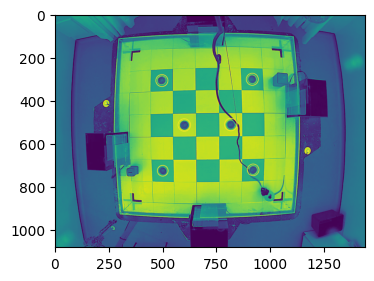

Are all sandwells correct - y/n? y


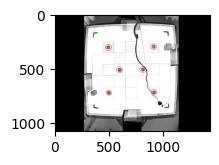

C:\Users\fr87_\AppData\Local\Temp\ipykernel_9480\2343195928.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  META.loc[SB_idxs, 'Location'] = 'N'
C:\Users\fr87_\AppData\Local\Temp\ipykernel_9480\813665369.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'W' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  META.loc[idxs, 'Trial Startbox'] = SBS[trial]
C:\Users\fr87_\AppData\Local\Temp\ipykernel_9480\813665369.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Correct' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  META.loc[idxs, 'Trial Status'] = T_status[trial][0

H2226 A 28 PRE 1


In [10]:
plot = False #plot trial DLC
plot_tstart = False #plot speed & detected trial start
save_plot = False #Save trial plot
t_start = 10 #Seconds to consider before the animal enters the arena
coord = True; #Standardize SAM CHO
All_META = []
ego_allo = Ego_Allo[2:]
ignore = ['H2234_E28_CHO1_events_dlc.csv', 'H2234_E28_SAM1_events_dlc.csv'] #trials excluded due to incorrect start detection


for file in sorted([i for i in os.listdir(EVEdir) if i.endswith('events_dlc.csv')], key=lambda x: int("".join([i for i in x if i.isdigit()]))):
    if file.endswith('events_dlc.csv'):
        E_A = file.split('_')[-4][0]
        Session = file.split('_')[-4][1:]
        Stage = file.split('_')[-3][:3]
        Trial = file.split('_')[-3][-1]

        #Loop through all SAM, CHO stages and add Trial meta
        if Stage in ['SAM', 'CHO'] :
            print(Animal_ID, E_A, Session, Stage, Trial)
            META = pd.read_csv(EVEdir+file)
            META.insert(loc = 1, column = 'TRIALS', value = Trial) 
            META.insert(loc = 2, column = 'Trial', value = 0)
            META.insert(loc = 3, column = 'Trial Startbox', value = 0)
            META.insert(loc = 4, column = 'Trial Status', value = 0)
            META.insert(loc = 5, column = 'Location', value = 0)
            
            if coord: #extract arena features (SW & Corners)         
#                 BEHvid = BEHdir+'%s_%s_%s_BEH.flv' %(Animal_ID, E_A+Session, Stage)
                BehVidname = pd.read_csv(homeDir+'\\Example Data\\Check_status2.csv')
                # the following is for the general loop, here as example data
                #BEHvid = BEHdir+'\\'+ BehVidname.loc[(BehVidname['Animal']==Animal_ID) & (BehVidname['Phase']==Ego_Allo)]['BEH'].values[0]
                BEHvid = BEHdir+'\\H2226_A28_PRE1_BEH.flv' #change here as needed
                bl_x, bl_y, tr_x, tr_y, w_x, w_y, sw_x, sw_y, cxn_x, cxn_y = arena_coodinates(BEHvid)
                max_coord = tr_x + 200
                max_coordy = tr_y + 200
                coord=False
            
            MetaSB, SBS, RW = startbox_indexs(META, bl_y, tr_x, tr_y, bl_x) #Define SBs
            SWS = sw_naming(sw_x, sw_y) #Define SWs
            TR_idxs = Trial_indexes(MetaSB, SB_thresh = 2, ego_allo = ego_allo) #Trial indexes
            TR_OB_idxs, T_status = Trial_indexes_outbound(TR_idxs, META, SWS, pix_cm = 5.2) #Outbound path indexes
            META.loc[[item for sublist in TR_OB_idxs for item in sublist], 'Location'] = 'Outbound'
            META.loc[MetaSB.index, 'Location'] = 'SB'
            c, c_label = speed(META[['cap_x', 'cap_y']].values,  pix_cm = 5.2, framerate=20) #Compute speed
            META['Speed'] = c; META['Movement status'] = c_label #REDUNDANCY
            
            if plot: #Plot all trials + meta
                fig = plt.figure(figsize=(8,3), dpi=200)
                fig.tight_layout()     
                fig.suptitle('%s %s %s T%s SB %s, SW %s' %(E_A, Session, Stage, Trial, ''.join(SBS), RW), fontsize=10, y=1.2)
                gs = gridspec.GridSpec(1, len(TR_idxs)+1, width_ratios=[3]*int(len(TR_idxs)+1)) #Can be improved
                gs.update(wspace=0.005)
                ax = plt.subplot(gs[0])
                plt.title('All', fontsize=8)
                plt.plot(META['cap_x'], META['cap_y'],c='lightgray', linewidth=0.5, zorder=0) # plot dlc 
                add_arena_details(sw_x, sw_y, SWS, bl_x, bl_y, w_x, w_y) #add arena borders & sws (Visual)
            
            #Loop through each trial: 1) Add meta 2) Plot 3)Save plot
            for trial, idxs in enumerate(TR_idxs):
                
                #1) Add meta
                META.loc[idxs, 'Trial'] = trial #ADD Trial META to META (can turn into func)
                if trial == 0:
                    META.loc[idxs, 'Trial Startbox'] = SBS[trial]
                    TSB = SBS[trial]
                else:
                    META.loc[idxs, 'Trial Startbox'] = SBS[-1]
                    TSB = SBS[-1]
                META.loc[idxs, 'Trial Status'] = T_status[trial][0]
                TSB_idxs = list(set(idxs).intersection(MetaSB[MetaSB['Location']==TSB].index)) #Trial SB indexes
                T_start_idxs = np.arange(TSB_idxs[-1]-40,TSB_idxs[-1]+20, 1)
                T_speed = np.argmin(META.loc[T_start_idxs]['Speed']) #Define trial using speed threshold
                T_start = META.loc[T_start_idxs[T_speed]]['Time (s)'] 
                META.loc[T_start_idxs[T_speed], 'Location'] = 'Trial start'
                if Session == 'E' and Stage == 'SAM':
                    print(TSB_idxs)
                if not plot and plot_tstart:
                    fig = plt.figure(figsize=(8,3), dpi=200)
                    ax = plt.subplot(gs[0])
                    plt.plot(idxs/20, META['Speed'][idxs], c='k')                
                    plt.plot([T_start_idxs[T_speed]/20]*2, [0,80], c='r', linestyle = '--');
                    plt.ylabel('Speed\n(cm/s)')
                    plt.xlabel('Trial Time (s)')
                    plt.savefig(SaveTo + 'Trial trajectories DLC\\%s\\%s_%s_%s_%s_TRIAL%s_T%s_SB%s_RW%s.png' %(Animal_ID, Animal_ID, E_A, Session, Stage, Trial, str(trial+1),''.join(SBS), RW), dpi=100, bbox_inches="tight")
                    plt.show()

                if plot: #Plot inividual trials
                    ax = plt.subplot(gs[trial+1])
                    plt.title('Trial %d\n %s\n(Tstart = %s)' %(trial+1, T_status[trial], str(int(T_start))), fontsize=8)
                    plt.plot(META['cap_x'][idxs], META['cap_y'][idxs],c='lightgray', linewidth=1, zorder=0) # plot dlc 
                    if T_status[trial][0] == 'Correct':
                        plt.plot(META['cap_x'][TR_OB_idxs[trial]], META['cap_y'][TR_OB_idxs[trial]],c='b', linewidth=1, zorder=0) # plot dlc 
                    else:
                        plt.plot(META['cap_x'][TR_OB_idxs[trial]], META['cap_y'][TR_OB_idxs[trial]],c='red', linewidth=1, zorder=0) # plot dlc 
                    plt.scatter(META.loc[T_start_idxs[T_speed]]['cap_x'], META.loc[T_start_idxs[T_speed]]['cap_y'], color='pink', s=5)
                    add_arena_details(sw_x, sw_y, SWS, bl_x, bl_y, w_x, w_y)
                
            if save_plot: #Save a small plot
                if not os.path.exists(SaveTo + 'Trial trajectories DLC/' + Animal_ID):
                    os.makedirs(SaveTo + 'Trial trajectories DLC/' + Animal_ID)
                plt.savefig(SaveTo + 'Trial trajectories DLC\\%s\\%s_%s_%s_%s_T%s_SB%s_SW%s.png' %(Animal_ID, Animal_ID, E_A, Session, Stage, Trial, ''.join(SBS), RW), dpi=300, bbox_inches="tight")
                plt.show()
            elif plot:
                plt.show()

            #Create super df
            if len(All_META) == 0: All_META = META
            else: All_META = pd.concat([All_META, META], ignore_index=True)
        
        elif Stage == 'PRE': #Add EXP to super df
            print(Animal_ID, E_A, Session, Stage, Trial)
            META = pd.read_csv(EVEdir+file)
            c, c_label = speed(META[['cap_x', 'cap_y']].values, pix_cm = 5.2, framerate=20) #Compute speed
            META['Speed'] = c; META['Movement status'] = c_label
            if len(All_META) == 0: All_META = META
            else: All_META = pd.concat([All_META, META], ignore_index=True)

All_META = update_trials(All_META)

In [ ]:
#Save concatenated df to directory
All_META.to_csv(os.path.join(homeDir, 'Data\\%s\\%s\\ALIGNED TRA EVE\\REGISTERED\\events\\Quality_checked\\%s_all_trials.csv' %(Animal_ID, Ego_Allo, Animal_ID)), index=False)

A28 CHO 1 Correct 31.399372 33 Events in SB.....


100%|██████████| 33/33 [00:02<00:00, 15.51it/s]

H2226_A28_CHO_Trial1_SBWN_RW6.png saved


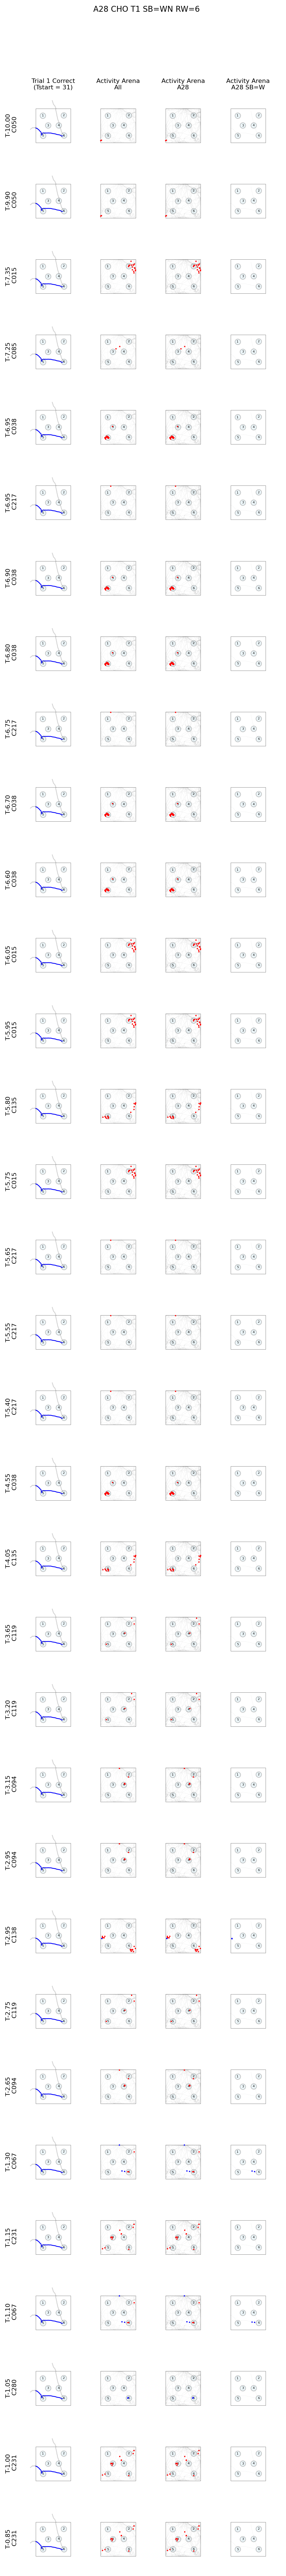

100%|██████████| 33/33 [00:08<00:00,  3.89it/s]

Trials that were not exported: []
Dont forget to add this to the To do analysis


In [11]:
st_colors = {'PRE':'r', 'SAM':'b', 'CHO':'b'}
ignore_trials = []
fix = []
wdw = 10
Sessions = np.unique(All_META['Session'])
for session in Sessions:
    for stage in ['SAM', 'CHO']:
        SB_st = All_META.loc[(All_META['Session'] == session) & (All_META['Stage'].str.contains(stage))]
        t = 1
        for trial_split in sorted(np.unique(SB_st['TRIALS'])):
            Meta_tsplit = SB_st[SB_st['TRIALS'] == trial_split]
            for trial in sorted(np.unique(Meta_tsplit['Trial'])):
                SB_tr = Meta_tsplit.loc[(Meta_tsplit['Trial'] == trial)]
                if SB_tr['Trial Status'].values[0] == 'Correct' and Animal_ID+session+stage+str(t) not in ignore_trials:
                    if len(SB_tr[SB_tr['Location'] == 'Trial start']) > 0:
                        Start_idx = SB_tr[SB_tr['Location'] == 'Trial start'].index[0]
                        RW = SB_tr['Rewarded well'].values[0]
                        SBS = SB_tr['Combo'].values[0]
                        Start_T = SB_tr.loc[Start_idx]['Time (s)']
                        SB_tr = SB_tr.loc[Start_idx-wdw*20:].reset_index(drop=True)
                        tr_cells = [i for i in SB_tr.columns if i.startswith(' C')] #Trial cells
                        SB_activity = SB_tr.loc[:wdw * 20][tr_cells].reset_index(drop=True)
                        SB_SB = SB_activity.values.T # SB activity
                        SB_cells = [cell for i, cell in enumerate(tr_cells) if np.sum(SB_SB[i]) > 0]
                        SB = SB_tr['Trial Startbox'].values[0]
                        SB_cells = sb_cells_ordered(SB_activity, SB_cells) #Sort

                        #Extract all arena activity 
                        META = All_META[All_META['Stage'].str.contains('PRE|SAM|CHO')]
                        SBS_idxs = []
                        SBS_idxs += list(META[META['cap_y'] < bl_y].index)
                        SBS_idxs += list(META[META['cap_x'] > tr_x].index)
                        SBS_idxs += list(META[META['cap_y'] > tr_y].index)
                        SBS_idxs += list(META[META['cap_x'] < bl_x].index)
                        META.loc[SBS_idxs, 'Location'] = 'SB'
                        META = META[META['Location'] != 'SB']          
                        AR_cells = [i for i in SB_cells['Cell'] if np.sum(META[i]) > 0]
                        AR_cells = SB_cells[SB_cells['Cell'].isin(AR_cells)]
                        print(session, stage, t, SB_tr['Trial Status'].values[0], Start_T, len(AR_cells), 'Events in SB.....')
                        if len(AR_cells)> 0:
                            #Col 2 Plot SB cells in All Sessions EXP, SAM, CHO (color coded)
                            prog = 1; row = 0
                            fig = plt.figure(figsize=(6,len(AR_cells)*1.6), dpi=200)
                            fig.tight_layout()    
                            fig.suptitle('%s %s T%s SB=%s RW=%s' %(session, stage, str(t), ''.join(SBS), RW), fontsize=10)
                            gs = gridspec.GridSpec(len(AR_cells), 4, width_ratios=[3]*4)
                            gs.update(wspace=0.001)
                            with tqdm(total=len(AR_cells[['Cell', 'Timestamp']].values)) as pbar:
                                for cell, ts in AR_cells[['Cell', 'Timestamp']].values:
                                    pbar.update()
                                    #Col 1 Plot Trial DLC
                                    ax = plt.subplot(gs[row,0])
                                    if row == 0:
                                        plt.title('Trial %d %s\n(Tstart = %d)' %(t, SB_tr['Trial Status'].values[0], int(Start_T)), fontsize=8)
                                    plt.plot(SB_tr['cap_x'], SB_tr['cap_y'],c='lightgray', linewidth=1, zorder=0) # plot dlc 
                                    plt.plot(SB_tr[SB_tr['Location'] == 'Outbound']['cap_x'], SB_tr[SB_tr['Location'] == 'Outbound']['cap_y'],c='b', linewidth=1, zorder=0) # plot dlc 
                                    add_arena_details(sw_x, sw_y, SWS, bl_x, bl_y, w_x, w_y)
                                    ax.set_ylabel('T-%.2f\n%s' %(wdw-(ts/20), cell), fontsize=8)                            
    
                                    #Col 2 Plot SB cells in All Sessions EXP, SAM, CHO (color coded)
                                    ax = plt.subplot(gs[row, 1])
                                    cell_xy = META[['Stage', cell,'cap_x','cap_y']]
                                    e_idxs = cell_xy[cell_xy[cell]>0]
                                    ex = list(e_idxs['cap_x'].values)
                                    ey = list(e_idxs['cap_y'].values)
                                    X = list(cell_xy['cap_x'].values) 
                                    Y = list(cell_xy['cap_y'].values)
                                    c_label = [st_colors[i[:-1]] for i in cell_xy.loc[e_idxs.index]['Stage']]
                                    if row == 0:
                                        plt.title('Activity Arena\nAll', fontsize=8)
                                    plt.plot(X, Y, c='lightgray',linewidth=0.05, zorder=0)
                                    plt.scatter(ex, ey, c=c_label, s = 0.5, zorder=10)
                                    add_arena_details(sw_x, sw_y, SWS, bl_x, bl_y, w_x, w_y)             
    
                                    #Col 3 Plot SB cells for that session EXP, SAM, CHO
                                    ax = plt.subplot(gs[row, 2])
                                    cell_xy = META[['Session', 'Stage', cell, 'cap_x','cap_y']]
                                    cell_xy = cell_xy[cell_xy['Session'] == session]                       
                                    e_idxs = cell_xy[cell_xy[cell]>0]
                                    ex = list(e_idxs['cap_x'].values); ey = list(e_idxs['cap_y'].values)
                                    X = list(cell_xy['cap_x'].values); Y = list(cell_xy['cap_y'].values)
                                    c_label = [st_colors[i[:-1]] for i in cell_xy.loc[e_idxs.index]['Stage']]
                                    if row == 0:
                                        plt.title('Activity Arena\n%s' %(session), fontsize=8)
                                    plt.plot(X, Y, c='lightgray',linewidth=0.1, zorder=0)
                                    plt.scatter(ex, ey, c=c_label, s = 0.5, zorder=10)
                                    add_arena_details(sw_x, sw_y, SWS, bl_x, bl_y, w_x, w_y)
    
                                    #Col 4 ALL sessions, only starting from that startbox
                                    ALL_SB = All_META.loc[(All_META['Session'] == session) & 
                                                          (All_META['Stage'].str.contains('SAM|CHO')) &
                                                          (All_META['Trial Startbox'] == SB) & 
                                                          (All_META['Location'] != 'SB')]
                                    cell_xy = ALL_SB[[cell,'cap_x','cap_y']]
                                    e_idxs = cell_xy[cell_xy[cell]>0]
                                    ex = list(e_idxs['cap_x'].values); ey = list(e_idxs['cap_y'].values)                        
                                    X = list(cell_xy['cap_x'].values); Y = list(cell_xy['cap_y'].values)
                                    ax = plt.subplot(gs[row, 3])
                                    if row == 0:
                                        plt.title('Activity Arena\n%s SB=%s' %(session, SB), fontsize=8)
                                    plt.plot(X, Y, c='lightgray',linewidth=0.1, zorder=0)
                                    plt.scatter(ex, ey, c='b', s = 0.5, zorder=10)
                                    add_arena_details(sw_x, sw_y, SWS, bl_x, bl_y, w_x, w_y)
                                    row +=1
                                fig = ax.get_figure()
                                fig.subplots_adjust(top=0.95)
                                if not os.path.exists(SaveTo + 'Startbox_cells\\' + Animal_ID):
                                    os.makedirs(SaveTo + 'Startbox_cells\\' + Animal_ID)
                                plt.savefig(SaveTo + 'Startbox_cells\\%s\\%s_%s_%s_%s_Trial%s_SB%s_RW%s.png' %(Animal_ID, Ego_Allo, Animal_ID, session, stage,str(t), ''.join(SBS), RW), dpi=200, bbox_inches="tight")
                                print('%s_%s_%s_Trial%s_SB%s_RW%s.png saved' %(Animal_ID, session, stage,str(t), ''.join(SBS), RW))
                                plt.show()
                        else:
                            print(Animal_ID+session+stage+'T'+trial_split+str(t) , ' has no cells firing')
                    else:
                        ignore_trials.append(Animal_ID+session+stage+'T'+trial_split+str(t))
                t+=1

print('Trials that were not exported:' ,ignore_trials)
print('Dont forget to add this to the To do analysis')